<h2>Recycling Identification</h2>
Using: Various Models with Help From: Nathan Inkawhich



### Prerequisites

In [0]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
#!pip3 install visdom
#import visdom

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Inputs

Can use a variety of models trained on imagenet: resnet, alexnet, vgg, squeezenet, densenet, inception

In [0]:
# Dataset directory (training)
data_dir = '/trashnet/'

# Model type [resnet, alexnet, vgg, squeezenet, densenet, inception]]
model_name = 'inception'

# Number of classes in the dataset
num_classes = 6

# Batch size for training (dependent on memory)
batch_size = 8

# Number of epochs to train for
num_epochs = 50

# Number of workers
num_workers = 4

# Feature extracting
feature_extract = False

### Helper Functions

Code for adjusting the model to fit our data

#### Model Training and Validation Code

`train_model` function handles the training and validation
* input: PyTorch model, a dictionary of dataloaders, a loss function, an optimizer, a specified number of epochs to train and validate for, and a boolean flag for when the model is an Inception model.

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, 
                is_inception=False):
  since = time.time()

  val_acc_history = []
  val_loss = []
  
  train_acc = []
  train_loss = []

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'validation']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  # Get model outputs and calculate loss
                  # Special case for inception because in training it has an auxiliary output. In train
                  #   mode we calculate the loss by summing the final output and the auxiliary output
                  #   but in testing we only consider the final output.
                  if is_inception and phase == 'train':
                      # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                      outputs, aux_outputs = model(inputs)
                      loss1 = criterion(outputs, labels)
                      loss2 = criterion(aux_outputs, labels)
                      loss = loss1 + 0.4*loss2
                  else:
                      outputs = model(inputs)
                      loss = criterion(outputs, labels)

                  _, preds = torch.max(outputs, 1)

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              # statistics
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

          epoch_loss = running_loss / len(dataloaders[phase].dataset)
          epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
          
          if phase == 'train':
            train_acc.append(epoch_acc.cpu().numpy())
            train_loss.append(epoch_loss)

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

          # deep copy the model
          if phase == 'validation' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
          if phase == 'validation':
              val_acc_history.append(epoch_acc.cpu().numpy())
              val_loss.append(epoch_loss)

      print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, val_acc_history#, val_loss, train_acc, train_loss

#### Set Model Parameters' .requires_grad attribute

Need to change `.requires_grad` to false for feature extraction so new gradients can be computed

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

### Initalize and Reshape the Networks

Reshaping of the network


In [0]:
def initialize_model(model_name, num_classes, feature_extract, 
                    use_pretrained=True):
  # Initialize these variables which will be set in this if statement. Each of these
  # variables is model specific.
  model_ft = None
  input_size = 0

  if model_name == "resnet":
      """ Resnet18
      """
      model_ft = models.resnet18(pretrained=use_pretrained)
      set_parameter_requires_grad(model_ft, feature_extract)
      num_ftrs = model_ft.fc.in_features
      model_ft.fc = nn.Linear(num_ftrs, num_classes)
      input_size = 224
      
  elif model_name == "alexnet":
      """ Alexnet
      """
      model_ft = models.alexnet(pretrained=use_pretrained)
      set_parameter_requires_grad(model_ft, feature_extract)
      num_ftrs = model_ft.classifier[6].in_features
      model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
      input_size = 224

  elif model_name == "vgg":
      """ VGG11_bn
      """
      model_ft = models.vgg11_bn(pretrained=use_pretrained)
      set_parameter_requires_grad(model_ft, feature_extract)
      num_ftrs = model_ft.classifier[6].in_features
      model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
      input_size = 224

  elif model_name == "squeezenet":
      """ Squeezenet
      """
      model_ft = models.squeezenet1_0(pretrained=use_pretrained)
      set_parameter_requires_grad(model_ft, feature_extract)
      model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
      model_ft.num_classes = num_classes
      input_size = 224

  elif model_name == "densenet":
      """ Densenet
      """
      model_ft = models.densenet121(pretrained=use_pretrained)
      set_parameter_requires_grad(model_ft, feature_extract)
      num_ftrs = model_ft.classifier.in_features
      model_ft.classifier = nn.Linear(num_ftrs, num_classes)
      input_size = 224

  elif model_name == "inception":
      """ Inception v3
      Be careful, expects (299,299) sized images and has auxiliary output
      """
      model_ft = models.inception_v3(pretrained=use_pretrained)
      set_parameter_requires_grad(model_ft, feature_extract)
      # Handle the auxilary net
      num_ftrs = model_ft.AuxLogits.fc.in_features
      model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
      # Handle the primary net
      num_ftrs = model_ft.fc.in_features
      model_ft.fc = nn.Linear(num_ftrs,num_classes)
      input_size = 299

  else:
      print("Invalid model name, exiting...")
      exit()

  return model_ft, input_size

In [7]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:05<00:00, 21695763.19it/s]


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

### Load Data

Data transformations to format images for the model

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

Initializing Datasets and Dataloaders...


In [0]:
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'validation']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=num_workers) for x in ['train', 'validation']}

In [0]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Create the Optimizer

Optimizer to only update the desired parameters. Shows all components that need to be updated

In [11]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 Conv2d_1a_3x3.conv.weight
	 Conv2d_1a_3x3.bn.weight
	 Conv2d_1a_3x3.bn.bias
	 Conv2d_2a_3x3.conv.weight
	 Conv2d_2a_3x3.bn.weight
	 Conv2d_2a_3x3.bn.bias
	 Conv2d_2b_3x3.conv.weight
	 Conv2d_2b_3x3.bn.weight
	 Conv2d_2b_3x3.bn.bias
	 Conv2d_3b_1x1.conv.weight
	 Conv2d_3b_1x1.bn.weight
	 Conv2d_3b_1x1.bn.bias
	 Conv2d_4a_3x3.conv.weight
	 Conv2d_4a_3x3.bn.weight
	 Conv2d_4a_3x3.bn.bias
	 Mixed_5b.branch1x1.conv.weight
	 Mixed_5b.branch1x1.bn.weight
	 Mixed_5b.branch1x1.bn.bias
	 Mixed_5b.branch5x5_1.conv.weight
	 Mixed_5b.branch5x5_1.bn.weight
	 Mixed_5b.branch5x5_1.bn.bias
	 Mixed_5b.branch5x5_2.conv.weight
	 Mixed_5b.branch5x5_2.bn.weight
	 Mixed_5b.branch5x5_2.bn.bias
	 Mixed_5b.branch3x3dbl_1.conv.weight
	 Mixed_5b.branch3x3dbl_1.bn.weight
	 Mixed_5b.branch3x3dbl_1.bn.bias
	 Mixed_5b.branch3x3dbl_2.conv.weight
	 Mixed_5b.branch3x3dbl_2.bn.weight
	 Mixed_5b.branch3x3dbl_2.bn.bias
	 Mixed_5b.branch3x3dbl_3.conv.weight
	 Mixed_5b.branch3x3dbl_3.bn.weight
	 Mixed_5b.b

### Training and Validation

Set up the loss for the model, then run the training and validation function for the set number of epochs

In [0]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

In [13]:
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, 
                             optimizer_ft, num_epochs=num_epochs, 
                             is_inception=(model_name=="inception"))

Epoch 0/49
----------
train Loss: 1.5561 Acc: 0.5751
validation Loss: 0.5099 Acc: 0.8281

Epoch 1/49
----------
train Loss: 1.0902 Acc: 0.7266
validation Loss: 0.4790 Acc: 0.8359

Epoch 2/49
----------
train Loss: 0.9342 Acc: 0.7675
validation Loss: 0.3211 Acc: 0.9141

Epoch 3/49
----------
train Loss: 0.8046 Acc: 0.7992
validation Loss: 0.3304 Acc: 0.8867

Epoch 4/49
----------
train Loss: 0.7364 Acc: 0.8076
validation Loss: 0.3374 Acc: 0.8984

Epoch 5/49
----------
train Loss: 0.6767 Acc: 0.8203
validation Loss: 0.2838 Acc: 0.9180

Epoch 6/49
----------
train Loss: 0.6648 Acc: 0.8322
validation Loss: 0.2523 Acc: 0.9023

Epoch 7/49
----------
train Loss: 0.5393 Acc: 0.8613
validation Loss: 0.1664 Acc: 0.9570

Epoch 8/49
----------
train Loss: 0.5950 Acc: 0.8556
validation Loss: 0.2756 Acc: 0.9023

Epoch 9/49
----------
train Loss: 0.4737 Acc: 0.8793
validation Loss: 0.1880 Acc: 0.9453

Epoch 10/49
----------
train Loss: 0.5049 Acc: 0.8763
validation Loss: 0.2336 Acc: 0.9336

Epoch 11/

In [0]:
categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

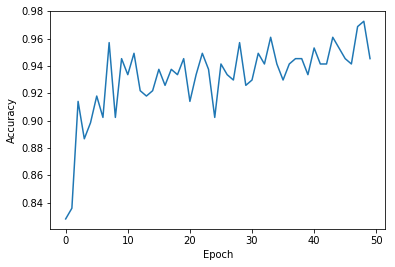

In [15]:
plt.plot(hist)
#epochs = [0,1, 2]
#plt.xticks(epochs)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Quick test

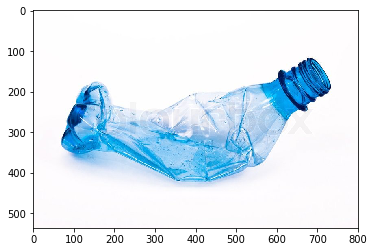

In [16]:
from PIL import *
img = Image.open('test.jpg')
plt.imshow(img)
data_transform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
img = data_transform(img)[None,:,:,:].to(device=torch.device('cuda:0'))
output = model_ft(img)

In [17]:
score, preds = torch.max(output, 1)
preds.cpu().numpy()[0]
categories[preds]

'plastic'

### Procedure
- [x] Reorganize Dataset to have a training and validation group
- [x] Initalize the pretrained model
- [x] Reshape the final layer(s) to have the same number of outputs as the number of classes in the new dataset
- [x] Define for the optimization algorithm which parameters we want to update during training
- [x] Run the training step